### Theory Integration

We mapped constucts across a collection of behaviour change theories to ontologies in order to determine commonalities and show how these theories can be integrated. 

Here we parse the theory mapping and quantitatively analyse the results. 

In [1]:
# conda activate ontos

! pip install openpyxl
! pip install pandas
! pip install py_horned_owl
! pip install whoosh
! pip install ontoutils
! pip install seaborn
! pip install graphviz

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [3]:
# Prepare LucidChart files for further processing
import os 

theory_dir = '../data/theories_2025/processed'
theories = [file for file in os.listdir(theory_dir) if file.endswith(".csv")]


In [4]:
# First load the theory database
import TheoryDatabase
from TheoryDatabase import Theory, theories, Relation

TheoryDatabase.__init__("TheoryDatabase")
TheoryDatabase.setup()
theory_names = sorted(theories.keys())


About to parse theory:  42 Norm Activation Theory
About to parse theory:  80 Theory of Triadic Influence
About to parse theory:  70 Social Learning Theory
About to parse theory:  1 Action Theory Model of Consumption
Error parsing relation data:   124 Line Part of 5 26
Error parsing relation data:   125 Line Part of 13 26
Error parsing relation data:   126 Line Part of 17 26
About to parse theory:  59 Six staged model of communication effects
About to parse theory:  34 Integrated Theory of Health Behaviour Change
About to parse theory:  2 Affective Events Theory
About to parse theory:  74 Temporal Self-Regulation Theory
About to parse theory:  64 Social consensus model of health education
About to parse theory:  54 Relapse Prevention Theory
About to parse theory:  49 Protection Motivation Theory
About to parse theory:  20 General Theory of Deviant Behaviour
About to parse theory:  6 Change Theory
About to parse theory:  44 Precaution Adoption Process Model
About to parse theory:  31 Inf

In [5]:
import pandas as pd 

# Get construct names in the theory database to use for matching
theory_constrs = [{"Theory":t,"Construct":theories[t].constructs[c].name.strip().lower().replace("'","").replace("  "," ")} for t in theories for c in theories[t].constructs]
df_theory_constrs = pd.DataFrame(theory_constrs)
df_theory_constrs

,Theory,Construct
0,42,perception of need and responsibility
1,42,awareness of need
2,42,perception that need can be relieved by action
3,42,recognition of own ability to provide relief
4,42,causal responsibility
...,...,...
1524,71,pluralistic ignorance
1525,71,false consensus
1526,71,false uniqueness
1527,71,healthy behaviour


In [6]:
len(pd.unique(df_theory_constrs['Theory']))

76

In [7]:
import openpyxl
import pandas as pd
import re

def parseConstructs(constructs_file):
    row_data = []
    out_of_scope_constructs = []  # List to store constructs that are "NotMappedOutOfScope" or "NotMappedUnclear"
    
    wb = openpyxl.load_workbook(constructs_file)
    sheet = wb['Sheet1']
    
    for row in sheet.iter_rows(min_row=2, min_col=0, max_row=1764, max_col=17):
        theory_num = row[0].value
        theory_name = row[1].value
        construct_name = row[2].value
        construct_defn = row[3].value
        ontology_id = row[5].value
        ontology_label = row[6].value
        alt_ontology_id = row[7].value
        alt_ontology_label = row[8].value
        alt_ontology_id2 = row[9].value
        alt_ontology_label2 = row[10].value
        alt_ontology_id3 = row[11].value
        alt_ontology_label3 = row[12].value
        mapping_notes = row[13].value  # after, skip two columns
        mapping_detail = row[16].value 

        if not (theory_num is None or construct_name is None):
            
            construct_name = construct_name.strip()
            query_result = df_theory_constrs.query(
            f"Theory == '{theory_num}' and Construct == '{construct_name.lower().replace("'", "").replace("\n", "").replace("  "," ")}'"
            )    
            
            if len(query_result) >= 1:
                if not (ontology_id is None or ontology_label is None or re.match("^Not", mapping_detail)):
                    theory_dict = {
                        "Theory_ID": theory_num,
                        "Theory_Name": theory_name,
                        "Construct": construct_name.strip(),
                        "Construct_Def": construct_defn,
                        "Ontology_ID": ontology_id.strip() if isinstance(ontology_id, str) else ontology_id,
                        "Ontology_Label": ontology_label.strip() if isinstance(ontology_label, str) else ontology_label,
                        "Alt_Ontology_ID": alt_ontology_id.strip() if alt_ontology_id else None,
                        "Alt_Ontology_Label": alt_ontology_label.strip() if alt_ontology_label else None,
                        "Alt_Ontology_ID_2": alt_ontology_id2.strip() if alt_ontology_id2 else None,
                        "Alt_Ontology_Label_2": alt_ontology_label2.strip() if alt_ontology_label2 else None,
                        "Alt_Ontology_ID_3": alt_ontology_id3.strip() if alt_ontology_id3 else None,
                        "Alt_Ontology_Label_3": alt_ontology_label3.strip() if alt_ontology_label3 else None,
                        "Mapping_Detail": mapping_detail
                    }
                    row_data.append(theory_dict)
                else:
                    if re.match("^Not", mapping_detail) :
                        # Save these constructs separately
                        out_of_scope_constructs.append({
                            "Theory_ID": theory_num,
                            "Theory_Name": theory_name,
                            "Construct": construct_name.strip(),
                            "Mapping_Detail": mapping_detail
                        })
                        
                    else:
                        print("Theory", theory_num, "and construct", construct_name, "have no annotations.")
            else: 
                print("Theory", theory_num, "and construct", construct_name, "do not appear to be in LucidChart.")
    
    df = pd.DataFrame(row_data)
    df_out_of_scope = pd.DataFrame(out_of_scope_constructs)  # Convert out-of-scope constructs to DataFrame
    
    return df, df_out_of_scope  # Return both DataFrames


In [9]:
#resultdata = parseConstructs("constructs/ConstructsOntologyMapping-20240819.xlsx")
resultdata, out_of_scope = parseConstructs("../data/definitions/Final Constructs (Across Theory Mapping).xlsx")
#resultdata = parseConstructs("/Users/hastingj/Work/Python/TheoryDatabase/definitions/Final Constructs (Across Theory Mapping).xlsx")

In [10]:
# Create a check: Which LucidChart Constructs are not in the Mapping Spreadsheet

for theory_id in theories:
    theory = theories[theory_id]
    # Convert construct names in resultdata to lowercase for case-insensitive matching
    construct_mapping_list = resultdata.loc[resultdata["Theory_ID"] == pd.to_numeric(theory_id), "Construct"].str.lower().tolist()
    out_of_scope_list = out_of_scope.loc[out_of_scope["Theory_ID"] == pd.to_numeric(theory_id), "Construct"].str.lower().tolist()
    construct_list = construct_mapping_list + out_of_scope_list
    #print(out_of_scope_list)
    for construct in theory.constructs.values():
        # Convert construct.name to lowercase before checking
        if construct.name.lower() not in construct_list:
            print("In theory", theory_id, construct.name, "does not appear to be in the mapping spreadsheet")


In theory 64  does not appear to be in the mapping spreadsheet
In theory 14  does not appear to be in the mapping spreadsheet
In theory 68  does not appear to be in the mapping spreadsheet


In [11]:
merged_lists = resultdata[['Ontology_ID', 'Alt_Ontology_ID', 'Alt_Ontology_ID_2', 'Alt_Ontology_ID_3']].apply(lambda row: row.tolist(), axis=1).tolist()
merged_lists = [ list(filter(lambda x: x is not None and x != "", l)) for l in merged_lists ]

#print(merged_lists)
print(len(merged_lists))

from collections import Counter

# Get the lengths of the inner lists
lengths = [len(l) for l in merged_lists]

# Use Counter to get the counts of each length
length_counts = Counter(lengths)

print(length_counts)


1459
Counter({1: 1243, 2: 187, 3: 28, 4: 1})


In [12]:
mapping_counts = resultdata['Mapping_Detail'].value_counts()

mapping_counts   # These don't seem to quite correspond to the final annotations -- things are flagged as 'not mapped' when sometimes they are.

Mapping_Detail
WellMapped                        845
MappedToBroaderTerm               393
MultiplyMappedMultipleMeanings    162
MultiplyMappedBroadMeaning         50
PartialMappingMultipleMeanings      5
MultiplyMappedAmbiguousMeaning      4
Name: count, dtype: int64

In [13]:
mapping_counts_oos = out_of_scope['Mapping_Detail'].value_counts()
mapping_counts_oos

Mapping_Detail
NotMappedOutOfScope    45
NotMappedUnclear       12
Name: count, dtype: int64

In [14]:
! wget https://raw.githubusercontent.com/HumanBehaviourChangeProject/ontologies/refs/heads/master/bcio.owl

--2025-09-09 17:22:12--  https://raw.githubusercontent.com/HumanBehaviourChangeProject/ontologies/refs/heads/master/bcio.owl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2032096 (1.9M) [text/plain]
Saving to: ‘bcio.owl’

bcio.owl            100%[===================>]   1.94M  --.-KB/s    in 0.1s    

2025-09-09 17:22:12 (13.0 MB/s) - ‘bcio.owl’ saved [2032096/2032096]



In [15]:
import pyhornedowl

ontoname = "bcio.owl" # Downloaded from GitHub to the local directory

onto = pyhornedowl.open_ontology(ontoname)

prefixes = [ ["ADDICTO","http://addictovocab.org/ADDICTO_"],
             ["BFO","http://purl.obolibrary.org/obo/BFO_"],
             ["CHEBI","http://purl.obolibrary.org/obo/CHEBI_"],
             ["UBERON","http://purl.obolibrary.org/obo/UBERON_"],
             ["PATO","http://purl.obolibrary.org/obo/PATO_"],
             ["BCIO","http://humanbehaviourchange.org/ontology/BCIO_"],
             ["SEPIO","http://purl.obolibrary.org/obo/SEPIO_"],
             ["OMRSE","http://purl.obolibrary.org/obo/OMRSE_"],
             ["OBCS","http://purl.obolibrary.org/obo/OBCS_"],
             ["OGMS","http://purl.obolibrary.org/obo/OGMS_"],
             ["ENVO","http://purl.obolibrary.org/obo/ENVO_"],
             ["OBI", "http://purl.obolibrary.org/obo/OBI_"],
             ["MF","http://purl.obolibrary.org/obo/MF_"],
             ["MFOEM","http://purl.obolibrary.org/obo/MFOEM_"],
             ["CHMO","http://purl.obolibrary.org/obo/CHMO_"],
             ["DOID","http://purl.obolibrary.org/obo/DOID_"],
             ["IAO","http://purl.obolibrary.org/obo/IAO_"],
             ["ERO","http://purl.obolibrary.org/obo/ERO_"],
             ["PO","http://purl.obolibrary.org/obo/PO_"],
             ["RO","http://purl.obolibrary.org/obo/RO_"],
             ["APOLLO_SV","http://purl.obolibrary.org/obo/APOLLO_SV_"],
             ["PDRO","http://purl.obolibrary.org/obo/PDRO_"],
             ["GAZ","http://purl.obolibrary.org/obo/GAZ_"],
             ["GSSO","http://purl.obolibrary.org/obo/GSSO_"], 
             ["GO","http://purl.obolibrary.org/obo/GO_"],
             ["NBO","http://purl.obolibrary.org/obo/NBO_"],
             ["RBBO","https://purl.org/turbbo/RBBO_"],
             ["GMHO", "https://galenos.org.uk/ontologies/GMHO_"],
             ["PR", "http://purl.obolibrary.org/obo/PR_"],
             ["STATO", "http://purl.obolibrary.org/obo/STATO_"],
             ["CMO", "http://purl.obolibrary.org/obo/CMO_"],
             ["EFO", "http://www.ebi.ac.uk/efo/EFO_"],
             ["OMIABIS", "http://purl.obolibrary.org/obo/OMIABIS_"],
             ["OPMI", "http://purl.obolibrary.org/obo/OPMI_"],
             ["COB", "http://purl.obolibrary.org/obo/COB_"],
            ["SDGIO", "http://purl.unep.org/sdg/SDGIO_"]
           ]

RDFSLABEL = "http://www.w3.org/2000/01/rdf-schema#label"

for prefix in prefixes:
    onto.add_prefix_mapping(prefix[0],prefix[1])

print (f"Loaded ontology has {len(onto.get_classes())} classes.")
print (f"Loaded ontology has {len(onto.get_axioms())} axioms.")

for c in onto.get_classes():
    print(onto.get_id_for_iri(c),onto.get_annotation(c, RDFSLABEL))


Loaded ontology has 2524 classes.
Loaded ontology has 16706 axioms.
BCIO:006046 action schema
BCIO:015114 adoptive parent
BCIO:007120 vicarious reward BCT
MFOEM:000226 appraisal of desirability
BCIO:006070 mental plan for a behaviour
BCIO:026026 secondary school
BCIO:009000 behaviour change intervention schedule of delivery
BCIO:015388 percentage higher education student role population statistic
BCIO:050355 prescribing medication
BCIO:050465 high physical exertion expended on behaviour
BCIO:010104 peer
BCIO:010036 librarian, archivist and curator
BCIO:006137 self-monitoring
BCIO:015290 proportion discipline of current programme of study or training population statistic
BCIO:015711 self employed status population statistic
BCIO:050796 well-specified goal
BCIO:015286 percentage disabled population statistic
BCIO:015466 percentage inpatient role population statistic
BCIO:050965 generalisation in learning
BFO:0000030 object
BCIO:006039 perceived norm
BCIO:036072 antisocial behaviour
BCIO:

In [16]:
ontoid_counts = resultdata['Ontology_ID'].value_counts()

for (cid, count) in ontoid_counts.items():
    if cid == 0: 
        continue
    ciri = onto.get_iri_for_id(cid)
    if ciri:
        clabel = onto.get_annotation(ciri, RDFSLABEL)
    else:
        print("No IRI found for ID",cid)
    if not clabel: 
        print(cid,ciri,clabel,count)



In [17]:
sum([len(theories[t].constructs) for t in theories])

1529

In [18]:
# Average, min and max number of annotations per theory
# group the annotations df by theory_id then count the rows with non-null ontology IDs, then plot

import statistics
import seaborn as sns
import matplotlib.pyplot as plt

theory_annotations = {}

for theory_id in theory_names:
    onto_ids = set(resultdata.query("Theory_ID == "+theory_id)['Ontology_ID'])
    #print(theory_id,":",onto_ids)
    theory_annotations[theory_id]=onto_ids

annot_nums = [(pd.to_numeric(n), len(t)) for n,t in theory_annotations.items()]
annot_nums

[(1, 29),
 (10, 17),
 (11, 10),
 (12, 16),
 (13, 37),
 (14, 19),
 (16, 19),
 (17, 25),
 (18, 6),
 (19, 13),
 (2, 7),
 (20, 8),
 (22, 16),
 (23, 23),
 (24, 23),
 (25, 14),
 (26, 12),
 (27, 10),
 (28, 18),
 (29, 32),
 (3, 19),
 (30, 20),
 (31, 22),
 (32, 14),
 (33, 20),
 (34, 17),
 (35, 16),
 (39, 21),
 (4, 28),
 (40, 6),
 (41, 32),
 (42, 21),
 (43, 17),
 (44, 7),
 (45, 13),
 (46, 13),
 (47, 10),
 (48, 9),
 (49, 21),
 (5, 16),
 (50, 10),
 (51, 16),
 (52, 18),
 (53, 13),
 (54, 20),
 (55, 9),
 (56, 22),
 (57, 32),
 (58, 18),
 (59, 19),
 (6, 7),
 (60, 45),
 (62, 11),
 (63, 9),
 (64, 11),
 (65, 18),
 (66, 23),
 (67, 15),
 (68, 11),
 (69, 22),
 (70, 16),
 (71, 7),
 (72, 23),
 (73, 17),
 (74, 9),
 (75, 7),
 (76, 11),
 (77, 16),
 (78, 17),
 (79, 14),
 (8, 10),
 (80, 26),
 (81, 11),
 (82, 13),
 (83, 13),
 (9, 10)]

In [19]:
print(len(annot_nums))
annot_nums_lens = [k for (a,k) in annot_nums]

print("Mean",statistics.mean(annot_nums_lens),"Max",max(annot_nums_lens),"Min",min(annot_nums_lens))

annot_nums.sort(key = lambda x: int(x[0]))

print(annot_nums)

76
Mean 16.644736842105264 Max 45 Min 6
[(1, 29), (2, 7), (3, 19), (4, 28), (5, 16), (6, 7), (8, 10), (9, 10), (10, 17), (11, 10), (12, 16), (13, 37), (14, 19), (16, 19), (17, 25), (18, 6), (19, 13), (20, 8), (22, 16), (23, 23), (24, 23), (25, 14), (26, 12), (27, 10), (28, 18), (29, 32), (30, 20), (31, 22), (32, 14), (33, 20), (34, 17), (35, 16), (39, 21), (40, 6), (41, 32), (42, 21), (43, 17), (44, 7), (45, 13), (46, 13), (47, 10), (48, 9), (49, 21), (50, 10), (51, 16), (52, 18), (53, 13), (54, 20), (55, 9), (56, 22), (57, 32), (58, 18), (59, 19), (60, 45), (62, 11), (63, 9), (64, 11), (65, 18), (66, 23), (67, 15), (68, 11), (69, 22), (70, 16), (71, 7), (72, 23), (73, 17), (74, 9), (75, 7), (76, 11), (77, 16), (78, 17), (79, 14), (80, 26), (81, 11), (82, 13), (83, 13)]


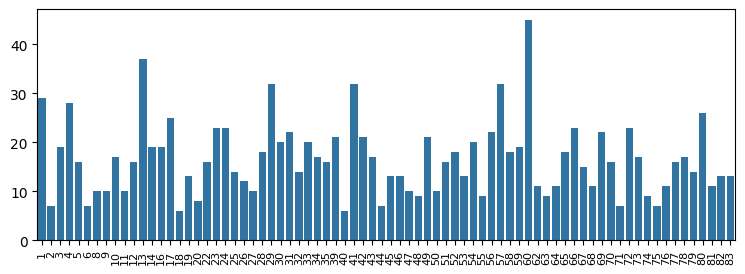

In [20]:
plt.figure(figsize=(9, 3))

sns.barplot({k:v for (k,v) in annot_nums})
plt.xticks(rotation=90,fontsize=8)
plt.show()

Minimum 0.47368421052631576 Mean 0.8471409194726501 Maximum 1.0


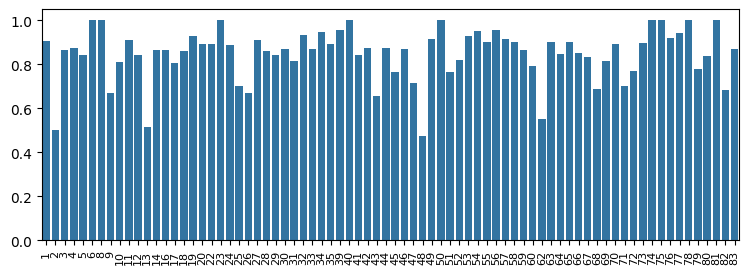

In [21]:
# As a proportion of the number of constructs as well ... 

theory_construct_lens = {pd.to_numeric(k):len(t.constructs) for k,t in theories.items()}

theory_proportion_annot = [(k,v/theory_construct_lens[k]) for k,v in annot_nums]

theory_proportion_annot

print("Minimum",min([v for (k,v) in theory_proportion_annot]),"Mean",statistics.mean([v for (k,v) in theory_proportion_annot]),"Maximum",max([v for (k,v) in theory_proportion_annot]))

plt.figure(figsize=(9, 3))
sns.barplot({k:v for (k,v) in theory_proportion_annot})
plt.xticks(rotation=90,fontsize=8)
plt.show()

#### Counts and interpretation of ontology annotation dataset

We look at the most common ontology annotations and visualise these 

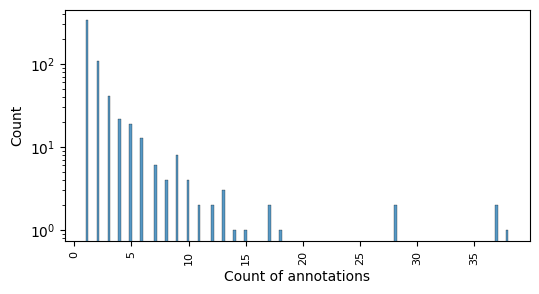

In [22]:
ontolabel_counts = {}

for (cid, count) in ontoid_counts.items():
    if isinstance(cid,str):
        ciri = onto.get_iri_for_id(cid)
        if ciri: 
            clabel = onto.get_annotation(ciri, RDFSLABEL)
            #print(cid,ciri,clabel,count)
            if clabel:
                ontolabel_counts[cid+" "+clabel]=count
            else: 
                ontolabel_counts[cid]=count


plt.figure(figsize=(6, 3))
sns.histplot(ontoid_counts.values ,log=True)
plt.xticks(rotation=90,fontsize=8)
plt.xlabel("Count of annotations")
plt.show()


In [23]:
ontocounts = {k:v for k,v in ontolabel_counts.items()}

#ontocounts
df_ontocounts = pd.DataFrame(list(ontocounts.items()), columns = ['Class', 'Count'])
df_ontocounts[['ID', 'label']] = df_ontocounts['Class'].str.split(' ', n=1, expand=True)
df_ontocounts = df_ontocounts.drop(columns=['Class'])

df_ontocounts.to_csv("classes_with_counts.csv", index = False)

df_ontocounts

,Count,ID,label
0,38,BCIO:006001,social environmental system
1,37,BCIO:036000,individual human behaviour
2,37,ENVO:01000254,environmental system
3,28,BCIO:006016,behavioural intention
4,28,BCIO:006154,self-efficacy belief for a behaviour
...,...,...,...
575,1,BCIO:050724,negotiating skill
576,1,BCIO:050640,emotional-relevance appraisal of possible cons...
577,1,BCIO:006070,mental plan for a behaviour
578,1,BCIO:050763,self-efficacy belief for a behaviour in the fa...


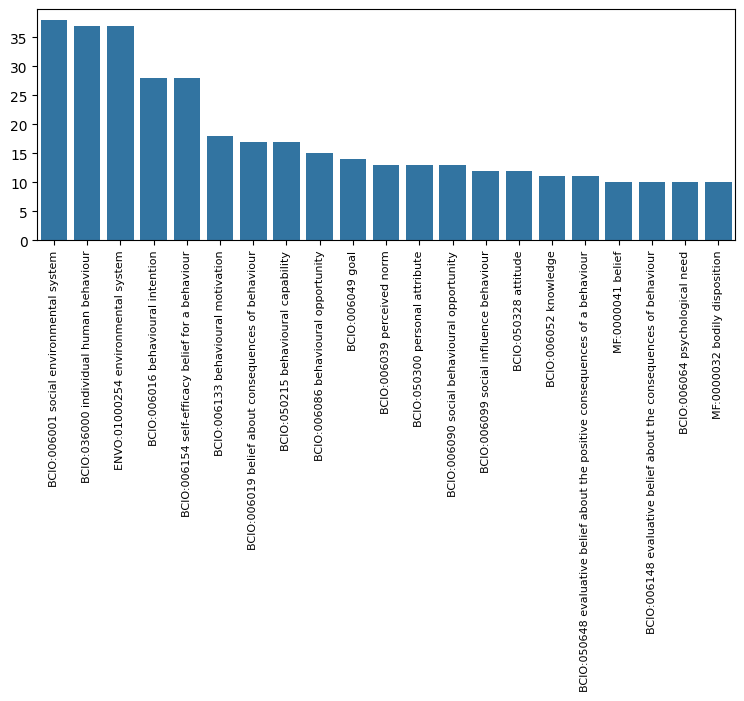

In [24]:
selected_ontocounts = {k:v for k,v in ontolabel_counts.items() if v>=10}

plt.figure(figsize=(9, 3))
sns.barplot(selected_ontocounts)
plt.xticks(rotation=90,fontsize=8)
plt.show()

In [25]:
selected_ontocounts

{'BCIO:006001 social environmental system': 38,
 'BCIO:036000 individual human behaviour': 37,
 'ENVO:01000254 environmental system': 37,
 'BCIO:006016 behavioural intention': 28,
 'BCIO:006154 self-efficacy belief for a behaviour': 28,
 'BCIO:006133 behavioural motivation': 18,
 'BCIO:006019 belief about consequences of behaviour': 17,
 'BCIO:050215 behavioural capability': 17,
 'BCIO:006086 behavioural opportunity': 15,
 'BCIO:006049 goal': 14,
 'BCIO:006039 perceived norm': 13,
 'BCIO:050300 personal attribute': 13,
 'BCIO:006090 social behavioural opportunity': 13,
 'BCIO:006099 social influence behaviour': 12,
 'BCIO:050328 attitude': 12,
 'BCIO:006052 knowledge': 11,
 'BCIO:050648 evaluative belief about the positive consequences of a behaviour': 11,
 'MF:0000041 belief': 10,
 'BCIO:006148 evaluative belief about the consequences of behaviour': 10,
 'BCIO:006064 psychological need': 10,
 'MF:0000032 bodily disposition': 10}


#### Interpret the annotations
We have loaded the annotation dataset, the ontology and the theory dataset. Now we would like to use the annotations to integrate across theories. 

- Statistics for overlaps between theories based on common annotations
- Percentage containment as was previously reported based on lexical matching. Now using ontology annotations. This answers the research question "which theories are comparable"? i.e. which theories partially overlap by referring to the same entities? 
- Maximal set of compatible and consistent entities and relationships as a single "mega-theory"
- Weighting of statements based on how often they appear in different theories, what are the most common statements? Mega-theory by consensus (voting)? 





#### Overlaps between theories based on common annotations

We calculate how many common annotations are shared pairwise between each combination of theories . This gives us a measure for how overlapping each pair of theories is. 


In [26]:
#print(theory_annotations)

theories_in_order = list(theory_annotations.keys())
theories_in_order.sort(key = lambda x: int(x))

theory_annot_overlaps = {}

for t1 in theories_in_order: 
    results_t1 = {}
    for t2 in theories_in_order: 
        onto_ids_t1 = theory_annotations[t1]
        onto_ids_t2 = theory_annotations[t2]
        overlaps = [value for value in onto_ids_t1 if value in onto_ids_t2]
        results_t1[t2]=overlaps
    theory_annot_overlaps[t1]=results_t1

print(theory_annot_overlaps)


{'1': {'1': ['BCIO:050592', 'ENVO:01000254', 'BCIO:006059', 'BCIO:050564', 'MFOEM:000053', 'BCIO:050328', 'MF:0000032', 'BCIO:050775', 'BCIO:006096', 'BCIO:050617', 'MFOEM:000001', 'MF:0000041', 'BCIO:050942', 'BCIO:050818', 'MF:0000045', 'BCIO:050453', 'BCIO:050590', 'BCIO:050708', 'BCIO:050817', 'BCIO:006016', 'BCIO:006042', 'ADDICTO:0001087', 'BCIO:050917', 'BCIO:007023', 'BCIO:006063', 'BCIO:050918', 'BCIO:006034', 'BCIO:006038', 'BCIO:050886'], '2': ['ENVO:01000254', 'BCIO:050328', 'MFOEM:000001'], '3': ['BCIO:006059', 'BCIO:006016'], '4': ['ENVO:01000254', 'BCIO:050328'], '5': ['ENVO:01000254'], '6': [], '8': [], '9': ['ENVO:01000254'], '10': ['ENVO:01000254', 'BCIO:050708'], '11': ['ENVO:01000254'], '12': [], '13': [], '14': ['ENVO:01000254', 'BCIO:050328', 'BCIO:006016', 'BCIO:006042'], '16': ['MF:0000032'], '17': ['BCIO:006096', 'MFOEM:000001', 'BCIO:050818'], '18': ['BCIO:006016'], '19': ['BCIO:050942'], '20': ['BCIO:006059'], '22': ['ENVO:01000254', 'MF:0000045', 'BCIO:00606

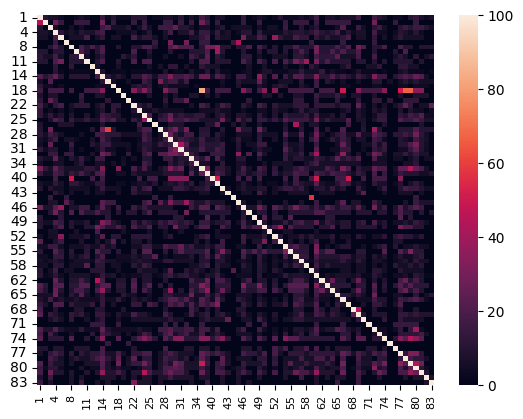

In [27]:
result_overlap_perc = []
annots_nums_dict = {str(k):v for (k,v) in annot_nums}

interesting_overlaps = {}

counter = 0
for t1 in theory_annot_overlaps:
    num_annots = annots_nums_dict[t1]
    if num_annots == 0: 
        print("Theory", t1, "has no annotations")
    else:
        result_overlap_perc.append([])
        for t2,overlaps in theory_annot_overlaps[t1].items():
            num_overlaps = len(overlaps)
            perc = num_overlaps / num_annots * 100
            result_overlap_perc[counter].append(perc)
            if perc < 100 and perc > 40:
                interesting_overlaps[t1+'-'+t2] = perc
        counter = counter+1

results_perc_overlap = pd.DataFrame(result_overlap_perc, theory_annot_overlaps.keys(),theory_annot_overlaps.keys())

results_perc_overlap


plt.figure()  # figsize=(9, 9)
sns.heatmap(results_perc_overlap)
plt.xticks(rotation=90,fontsize=8)
plt.show()

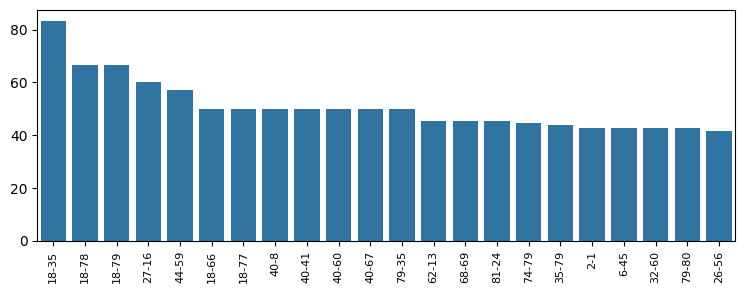

In [28]:
# Select just the higher ones...

interesting_overlaps_sorted = [ (k,v) for k,v in interesting_overlaps.items()]
interesting_overlaps_sorted.sort(reverse=True, key=lambda x: x[1])
interesting_overlaps_sorted

plt.figure(figsize=(9, 3))
sns.barplot({k:v for (k,v) in interesting_overlaps_sorted})
plt.xticks(rotation=90,fontsize=8)
plt.show()

#### Common Assertions

We collapse the theory assertions to triples using the ontology annotations rather than the construct labels. 
Then we look at how common the assertions are across different theories. 


In [29]:
annotated_triples = []

for theory_num, theory in theories.items():
    for triple in theory.triples:
        if triple.reified_rel is None: # Ignore the reified rels - too complex for this process now
            construct1 = triple.const1.name
            construct2 = triple.const2.name
            #print(f"Construct 1: '{construct1}', Construct 2: '{construct2}'")
            relationship = triple.relStr
            if 'relationship' not in construct1 and 'relationship' not in construct2:
                c1annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct1.lower().replace("\n","").replace("'","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                c2annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct2.lower().replace("\n","").replace("'","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                constr1_annots = [c for c in c1annots.values.flatten().tolist() if c]
                constr2_annots = [c for c in c2annots.values.flatten().tolist() if c]
                if len(constr1_annots)>0 and len(constr2_annots)>0: 
                    for annot1 in constr1_annots: 
                        for annot2 in constr2_annots:
                            if annot1 != annot2: 
                                a1iri = onto.get_iri_for_id(annot1)
                                a2iri = onto.get_iri_for_id(annot2)
                                a1label = onto.get_annotation(a1iri, RDFSLABEL) if a1iri else annot1
                                a2label = onto.get_annotation(a2iri, RDFSLABEL) if a2iri else annot2
                                #print("Theory",theory_num,"Construct1",construct1,"Annot1",annot1,"Rel",relationship,"Construct2",construct2,"Annot2",annot2)

                                annotated_triples.append( (annot1,a1label,relationship,annot2,a2label) )
                else:
                    print("Not including",theory_num,construct1,constr1_annots,construct2,constr2_annots)

#annotated_triples

Not including 31 Moderating variables [] Adherence motivation ['BCIO:006133']
Not including 31 Moderating variables [] Information ['BCIO:006056']
Not including 31 Moderating variables [] Adherence behavioural skills ['BCIO:050215', 'BCIO:006154']
Not including 31 Stable or unstable living conditions ['BCIO:050782'] Moderating variables []
Not including 31 Ease of access to medication and medical services ['BCIO:006088'] Moderating variables []
Not including 31 Psychological health ['BCIO:050736'] Moderating variables []
Not including 31 Chemical dependency ['ADDICTO:0001140'] Moderating variables []
Not including 31 Viral load [] Health outcomes ['BCIO:050806']
Not including 31 CD-4 count [] Health outcomes ['BCIO:050806']
Not including 31 Drug resistance [] Health outcomes ['BCIO:050806']
Not including 52 Truth values [] Relational schemata ['MF:0000031']
Not including 4 Communication with others ['BCIO:036034'] Partner's sexual pleasure []
Not including 4 Partner's sexual pleasure [

In [30]:
from collections import Counter

cnt = Counter(annotated_triples)

cnt

Counter({('BCIO:006001',
          'social environmental system',
          'Part of',
          'ENVO:01000254',
          'environmental system'): 10,
         ('BFO:0000038',
          'one-dimensional temporal region',
          'Transitions to',
          'BCIO:050924',
          'behaviour non-intender'): 9,
         ('BCIO:006001',
          'social environmental system',
          'Part of',
          'BCIO:006086',
          'behavioural opportunity'): 9,
         ('BCIO:050922',
          'behaviour enacter',
          'Transitions to',
          'BFO:0000038',
          'one-dimensional temporal region'): 7,
         ('BCIO:050922',
          'behaviour enacter',
          'Transitions to',
          'BCIO:050924',
          'behaviour non-intender'): 6,
         ('BCIO:050671',
          'group evaluative behavioural norm',
          'Part of',
          'BCIO:006001',
          'social environmental system'): 6,
         ('BCIO:006125',
          'operant conditioning',
  

In [31]:
triples_with_counts = []

for a,c in cnt.most_common():
    (a1,a1l,rel,a2,a2l) = a
    if isinstance(a1,str) and isinstance(a2,str):
        print(a1l, a1, rel, a2l, a2, c)
        triples_with_counts.append({"A1":a1,"A1Label":a1l,"Rel":rel,"A2":a2,"A2Label":a2l,"Count":c })
    else: 
        print(a1,rel,a2, "... some problem with IDs")

df_triple_counts = pd.DataFrame(triples_with_counts)
df_triple_counts.to_csv("triples_with_counts.csv",index=False)



social environmental system BCIO:006001 Part of environmental system ENVO:01000254 10
one-dimensional temporal region BFO:0000038 Transitions to behaviour non-intender BCIO:050924 9
social environmental system BCIO:006001 Part of behavioural opportunity BCIO:006086 9
behaviour enacter BCIO:050922 Transitions to one-dimensional temporal region BFO:0000038 7
behaviour enacter BCIO:050922 Transitions to behaviour non-intender BCIO:050924 6
group evaluative behavioural norm BCIO:050671 Part of social environmental system BCIO:006001 6
operant conditioning BCIO:006125 Type of intermittent schedule of reinforcement BCIO:050684 5
behavioural motivation BCIO:006133 Influences individual human behaviour BCIO:036000 4
evaluative belief BCIO:006038 Influences individual human behaviour BCIO:036000 4
behaviour pattern maintenance BCIO:050805 Transitions to one-dimensional temporal region BFO:0000038 4
one-dimensional temporal region BFO:0000038 Transitions to intention to enact a behaviour BCIO:05

In [32]:
triples_mean = statistics.mean(df_triple_counts['Count'])
triples_min = min(df_triple_counts['Count'])
triples_max = max(df_triple_counts['Count'])
triples_sd = statistics.stdev(df_triple_counts['Count'])
triples_perc1 = statistics.mean(df_triple_counts['Count'] == 1)
print(triples_mean, triples_min, triples_max, triples_sd, triples_perc1)

1.11448395490026 1 10 0.5235355511120853 0.924978317432784


In [33]:
relationships = [sublist[2] for sublist in annotated_triples]


Counter(relationships)


Counter({'Influences': 970,
         'Part of': 862,
         'Type of': 359,
         'Influences (*)': 129,
         'Positively influences': 110,
         'Transitions to': 91,
         'Correlates with': 25,
         'Negatively influences': 17,
         'Influences (+)': 4,
         'May influence': 2,
         'Has attribute': 1})

#### Generate a diagram for an integrated set of theory expressions

We generate a diagram representing an "overarching" integrated set of theory expressions


In [34]:
! pip install networkx
! pip install pydot
! pip install graphviz

In [35]:
import networkx as nx

def wrap_if_needed(string_val):
    if ":" in string_val:
        return( f'"{string_val}"')
    return(string_val)

G=nx.DiGraph()

for (a1,a1l,rel,a2,a2l) in annotated_triples:
    if cnt[(a1,a1l,rel,a2,a2l)]>1 and isinstance(a1,str) and isinstance(a2,str):    
        if a1l is None or a2l is None:   # Exclude those for which we didn't yet find a label
            continue
        G.add_node(wrap_if_needed(a1l))
        G.add_node(wrap_if_needed(a2l))
        G.add_edge(wrap_if_needed(a1l),wrap_if_needed(a2l),label=rel,penwidth=str(cnt[(a1,a1l,rel,a2,a2l)]))
    
pdot = nx.drawing.nx_pydot.to_pydot(G)

for i, node in enumerate(pdot.get_nodes()):
    node_name = str(node).replace("\"","").replace(";","")
    node.set_shape('box')
    node.set_fontcolor('black')
    node.set_fillcolor('white')
    node.set_style('rounded, filled')
    node.set_color('black')

png_path = "merged-large.png"
pdot.write_png(png_path)

/var/folders/wr/4fyz19y54_3_8gp5lh28w05xl0jvvw/T/ipykernel_45000/1797876452.py:18: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pdot = nx.drawing.nx_pydot.to_pydot(G)


In [36]:
# A smaller file with just a selected set of nodes

# based on deepseek
important_nodes = ["MF:0000008","BCIO:036000","BCIO:006086","MFOEM:000195","BCIO:006016","BCIO:006099","ENVO:01000254","BCIO:006133","BCIO:006154","BCIO:006047"]

# based on chatGPT (version 11-07-2025)

important_nodes = ["BCIO:036000",
                   "BCIO:006099", 
                   "BFO:0000038", 
                   "BCIO:050924", 
                   "BCIO:050922", 
                   "BCIO:006048",
                   "BCIO:006016",
                   "BCIO:006133",
                   "ENVO:01000254",
                   "BCIO:006001",
                   "BCIO:006086",
                   "BCIO:006038",
                   "BCIO:050671"]

G=nx.DiGraph()

for (a1,a1l,rel,a2,a2l) in annotated_triples:
    if cnt[(a1,a1l,rel,a2,a2l)]>1 and isinstance(a1,str) and isinstance(a2,str):    
        if a1l is None or a2l is None:   # Exclude those for which we didn't yet find a label
            continue
        if a1 in important_nodes and a2 in important_nodes: 
            G.add_node(wrap_if_needed(a1l))
            G.add_node(wrap_if_needed(a2l))
            G.add_edge(wrap_if_needed(a1l),wrap_if_needed(a2l),label=rel,penwidth=str(cnt[(a1,a1l,rel,a2,a2l)]))
    
pdot = nx.drawing.nx_pydot.to_pydot(G)

for i, node in enumerate(pdot.get_nodes()):
    node_name = str(node).replace("\"","").replace(";","")
    node.set_shape('box')
    node.set_fontcolor('black')
    node.set_fillcolor('white')
    node.set_style('rounded, filled')
    node.set_color('black')

png_path = "merged-medium.png"
pdot.write_png(png_path)

/var/folders/wr/4fyz19y54_3_8gp5lh28w05xl0jvvw/T/ipykernel_45000/3647222794.py:33: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pdot = nx.drawing.nx_pydot.to_pydot(G)


### Using the class hierarchy to integrate theories

We aim to use the ontology class hierarchy to expand the annotations and use the expanded annotations to integrate across the theories to form an overarching "integrated" theory. 

Some ideas: 
- Selective replacement of subclasses with superclasses in less-frequent triples to 'generalise' 
- Associate information content with class hierarchy in order to find the most informative "level" in the class hierarchy?
- Some kind of enrichment analysis algorithm?